“Risk parity portfolios allocate capital such that each asset contributes equally to total portfolio volatility. This approach mitigates concentration risk inherent in mean-variance portfolios and provides more stable drawdown behavior across market regimes.”

In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from utils.config import PROCESSED_RETURNS_PARQUET
from utils.analytics import (
    annualize_return,
    annualize_vol,
    max_drawdown_from_returns,
)


In [3]:
rets = pd.read_parquet(PROCESSED_RETURNS_PARQUET)
rets = rets.dropna(how="any")

assets = rets.columns.tolist()
n_assets = len(assets)

cov = rets.cov().values


In [4]:
def portfolio_vol(weights, cov):
    return np.sqrt(weights.T @ cov @ weights)


In [5]:
def marginal_risk_contribution(weights, cov):
    port_vol = portfolio_vol(weights, cov)
    return (cov @ weights) / port_vol


In [6]:
def component_risk_contribution(weights, cov):
    return weights * marginal_risk_contribution(weights, cov)


In [7]:
def risk_parity_objective(weights, cov):
    crc = component_risk_contribution(weights, cov)
    target = np.mean(crc)
    return np.sum((crc - target) ** 2)


In [8]:
constraints = (
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
)

bounds = [(0.0, 0.10) for _ in range(n_assets)]

x0 = np.repeat(1 / n_assets, n_assets)

res = minimize(
    risk_parity_objective,
    x0=x0,
    args=(cov,),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    options={"maxiter": 10_000},
)

w_rp = res.x
rp_returns = rets @ w_rp


In [9]:
crc = component_risk_contribution(w_rp, cov)
risk_df = pd.DataFrame({
    "weight": w_rp,
    "risk_contribution": crc,
    "risk_pct": crc / crc.sum(),
}, index=assets)

risk_df.sort_values("risk_pct", ascending=False).head(10)


,weight,risk_contribution,risk_pct
TSLA,0.022222,0.000423,0.047528
NVDA,0.022222,0.000411,0.046181
META,0.022222,0.000316,0.035479
BAC,0.022222,0.000304,0.034108
GS,0.022222,0.000301,0.033821
XLK,0.022222,0.000287,0.032213
AMZN,0.022222,0.000286,0.032177
AAPL,0.022222,0.000283,0.031849
MSFT,0.022222,0.000277,0.031132
XLE,0.022222,0.000275,0.030922


In [10]:
summary = pd.DataFrame([{
    "portfolio": "Risk Parity",
    "ann_return": annualize_return(rp_returns),
    "ann_vol": annualize_vol(rp_returns),
    "sharpe": annualize_return(rp_returns) / annualize_vol(rp_returns),
    "max_drawdown": max_drawdown_from_returns(rp_returns),
}])

summary


,portfolio,ann_return,ann_vol,sharpe,max_drawdown
0,Risk Parity,0.124997,0.141254,0.884914,-0.297239


In [11]:
baseline_perf = pd.read_csv("data/processed/baseline_performance.csv", index_col=0)

baseline_perf


,portfolio,ann_return,ann_vol,sharpe,max_drawdown
0,Equal Weight,0.124997,0.141254,0.884914,-0.297239
1,Mean-Variance,0.043268,0.054300,0.796829,-0.134735


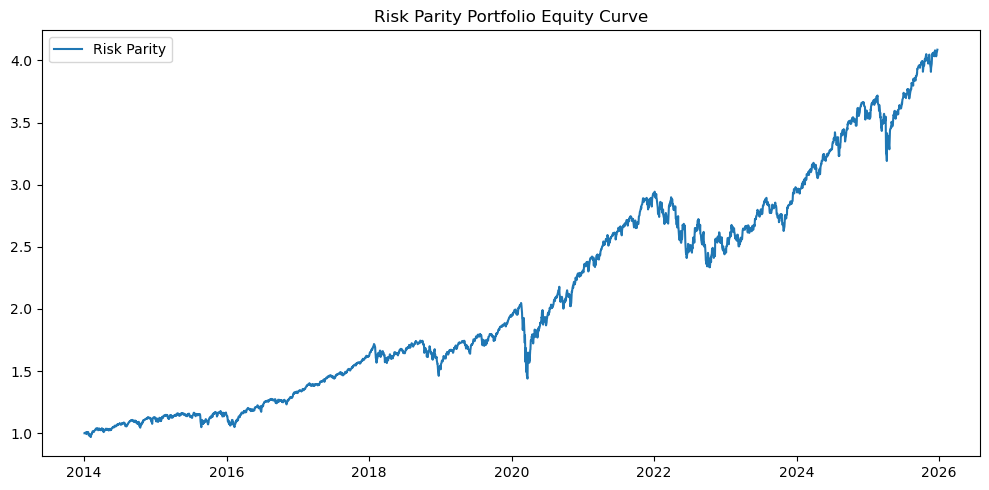

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(np.exp(rp_returns.cumsum()), label="Risk Parity")
plt.title("Risk Parity Portfolio Equity Curve")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
risk_df.to_csv("data/processed/risk_parity_weights_and_risk.csv")
summary.to_csv("data/processed/risk_parity_performance.csv")
